## Задача

Решить задачу машинного перевода выбрав свой язык:

● Формируем датасет с исходного языка на целевой (код прописать в классе)

● Строим архитектуру нейронной сети

● Обучаем

● Проверить качество с помощью метрики BLEU

## Решение

In [1]:
from io import open

import re
import random
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 1. Подготовка датасета к анализу

#### 1.1 Загрузка и очистка исходного словаря выражений

Загрузим англо-беларусский словарь выражений

In [2]:
raw_text = open('data/%s_%s.txt' % ("eng", "bel"), encoding='utf-8').read().strip()

In [3]:
raw_text

'Hi.\tДабрыдзень.\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #8004346 (seveleu_dubrovnik)\nWow!\tНішто сабе!\tCC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #8004911 (seveleu_dubrovnik)\nFire!\tАгонь!\tCC-BY 2.0 (France) Attribution: tatoeba.org #1829639 (Spamster) & #8004318 (seveleu_dubrovnik)\nJump.\tСкачы!\tCC-BY 2.0 (France) Attribution: tatoeba.org #631038 (Shishir) & #8004593 (seveleu_dubrovnik)\nStop!\tСпыніся!\tCC-BY 2.0 (France) Attribution: tatoeba.org #448320 (CM) & #11551161 (Palina)\nWait!\tПачакай!\tCC-BY 2.0 (France) Attribution: tatoeba.org #1744314 (belgavox) & #8004778 (seveleu_dubrovnik)\nHello!\tПрывітанне.\tCC-BY 2.0 (France) Attribution: tatoeba.org #373330 (CK) & #385433 (Demetrius2)\nHello!\tВітаю.\tCC-BY 2.0 (France) Attribution: tatoeba.org #373330 (CK) & #385434 (Demetrius2)\nHello!\tАло.\tCC-BY 2.0 (France) Attribution: tatoeba.org #373330 (CK) & #385435 (Demetrius2)\nHello!\tДабрыдзень.\tCC-BY 2.0 (France) Attribution: tatoeb

Представленный выше исходный текст представляет собой словарь выражений, дополненный мета-данными, касающимися автора, добавившего соответствующие пары в словарь. Эти мета-данные нам бесполезны, поэтому удалим их с помощью регулярного выражения.

In [4]:
cleaned_text = re.sub(r'\tCC-BY 2.0[^\n]*', '', raw_text)

# Разбиваем строку по строкам и затем по табуляциям "\t"
lines = [line for line in cleaned_text.splitlines()]

В итоге получили словарь в формате списка, состоящий из пар выражений на английском и беларусском языках, разделенных табуляцией (\t).

In [5]:
print(len(lines))
lines[111]

3938


"I'm angry.\tЯ злуюся."

В словаре, кроме букв английского и беларусского алфавитов, могут присутствовать и иные символы, которые считаются лишними (например, цифры) и могут создать проблемы с кодировкой. Поэтому с помощью функции, в основе которой лежит регулярное выражение, отделим буквы английского и беларусского алфавитов, а также знаки препинания ".!?", а остальные символы заменим на пробел. Поскольку беларусский алфавит содержит некоторые буквы, отсутствующие в русском алфавите, то мы не можем использовать сокращенное представление алфавита, как в случае английского алфавита, поэтому укажем весь беларусский словарь целиком.

In [6]:
def normalize_string(s: str) -> str:
    """
    Приведение строки к нижнему регистру, удаление лишних пробелов,
    обработка сокращений и символов препинания.

    Args:
        s (str): Входная строка для нормализации.

    Returns:
        str: Нормализованная строка.
    """
    s = s.lower().strip()
    # Для отделения символов ".!?" от предшествующего слова и корректного добавления слов в словари 
    s = re.sub(r"([.!?])", r" \1", s)

    # Заменяем сокращения в каждом элементе списка, если они присутствуют
    s = s.replace("'s", " is").\
        replace("isn't", "is not").\
        replace("'re", " are").\
        replace("aren't", "are not").\
        replace("'m", " am").\
        replace("'ve", " have").\
        replace("'ll", " will").\
        replace("'d", " would").\
        replace("won't", "will not").\
        replace("didn't", "did not").\
        replace("doesn't", "does not").\
        replace("don't", "do not").\
        replace("haven't", "have not").\
        replace("hasn't", "has not").\
        replace("hadn't", "had not")
    s = re.sub(r"[^a-zA-ZабвгдеёжзійклмнопрстуўфхцчшщыьэюяАБВГДЕЁЖЗІЙКЛМНОПРСТУЎФХЦЧШЩЫЬЭЮЯ.!?']+", r" ", s)
    
    return s

Мы получили очищенный англо-беларусский словарь в удобном для дальнейшей работы формате.

#### 1.2 Создание англо-беларусского словаря слов

Для возможности машинного перевода нам необходимо преобразовать словарь выражений в словарь слов. Выполним это с помощью класса LanguageVocabulary

In [7]:
# Два токена, которые определяют начало и конец выражения
SOS_TOKEN = 0
EOS_TOKEN = 1

class LanguageVocabulary:
    """
    Класс для управления словарем языка, содержащий методы для добавления слов и предложений.

    Атрибуты:
        name (str): Имя языка.
        word2index (dict): Словарь для хранения индексов слов.
        word2count (dict): Словарь для подсчета частоты использования слов.
        index2word (dict): Словарь для хранения слов по их индексам.
        n_words (int): Общее количество уникальных слов (включая SOS и EOS токены).
    """

    def __init__(self, name):
        """
        Инициализация экземпляра словаря.

        Аргументы:
            name (str): Имя языка.
        """
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {SOS_TOKEN: "SOS", EOS_TOKEN: "EOS"}
        self.n_words = 2

    def add_sentence(self, sentence):
        """
        Добавляет предложение в словарь, разбивая его на отдельные слова.

        Аргументы:
            sentence (str): Входная строка с предложением.
        """
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        """
        Добавляет слово в словарь, если оно отсутствует, либо увеличивает его счетчик.

        Аргументы:
            word (str): Входное слово для добавления.
        """
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

Создадим класс LanguageDataPreparer, который на основе созданного ранее класса LanguageVocabulary, будет получать отдельные пары предложений, разделять пары на отдельные слова английского и беларусского языка и добавлять их в созданные словари слов для каждого языка. Аргумент reverse позволяет создать словарь любой направленности: либо англо-беларусский, либо беларусско-английский.

In [8]:
class LanguageDataPreparer:
    """
    Класс для чтения и подготовки языковых данных.

    Атрибуты:
        lang1 (str): Имя первого языка.
        lang2 (str): Имя второго языка.
        reverse (bool): Флаг для обратного порядка пар языков.
        input_lang (LanguageVocabulary): Словарь для входного языка.
        output_lang (LanguageVocabulary): Словарь для выходного языка.
        pairs (list): Список пар предложений.
    """

    def __init__(self, lang1, lang2, reverse=False):
        """
        Инициализация класса с именами языков и опциональным флагом обратного порядка.

        Аргументы:
            lang1 (str): Имя первого языка.
            lang2 (str): Имя второго языка.
            reverse (bool): Флаг для обратного порядка пар языков.
        """
        self.lang1 = lang1
        self.lang2 = lang2
        self.reverse = reverse
        self.input_lang = None
        self.output_lang = None
        self.pairs = []

    def read_languages(self):
        """
        Читает данные для указанных языков и готовит пары предложений.

        Возвращает:
            input_lang (LanguageVocabulary): Словарь для входного языка.
            output_lang (LanguageVocabulary): Словарь для выходного языка.
            pairs (list): Список пар предложений.
        """
        print("Reading lines...")
        self.pairs = [[normalize_string(s) for s in line.split('\t')] for line in lines]
        if self.reverse:
            self.pairs = [list(reversed(p)) for p in self.pairs]
            self.input_lang = LanguageVocabulary(self.lang2)
            self.output_lang = LanguageVocabulary(self.lang1)
        else:
            self.input_lang = LanguageVocabulary(self.lang1)
            self.output_lang = LanguageVocabulary(self.lang2)
        return self.input_lang, self.output_lang, self.pairs

    def prepare_data(self):
        """
        Подготавливает данные для указанных языков: читает пары предложений,
        добавляет слова в словари и выводит информацию о количестве слов.
        
        Возвращает:
            input_lang (LanguageVocabulary): Словарь для входного языка.
            output_lang (LanguageVocabulary): Словарь для выходного языка.
            pairs (list): Список пар предложений.
        """
        input_lang, output_lang, pairs = self.read_languages()
        print("Read %s sentence pairs" % len(pairs))
        print("Trimmed to %s sentence pairs" % len(pairs))
        print("Counting words...")
        for pair in pairs:
            input_lang.add_sentence(pair[0])
            output_lang.add_sentence(pair[1])
        print("Counted words:")
        print(input_lang.name, input_lang.n_words)
        print(output_lang.name, output_lang.n_words)
        return input_lang, output_lang, pairs

In [9]:
preparer = LanguageDataPreparer('eng', 'bel', reverse=False)
input_lang, output_lang, pairs = preparer.prepare_data()
print(random.choice(pairs))

Reading lines...
Read 3938 sentence pairs
Trimmed to 3938 sentence pairs
Counting words...
Counted words:
eng 2340
bel 4313
['give a man a mask and he will tell the truth .', 'дай чалавеку маску і ён раскажа праўду .']


Словарь довольно небольшой. Наверняка, это скажется на качестве модели машинного обучения. Тем не менее, постараемся добиться максимально высоких результатов, используя данный словарь.

### 2. Создание архитектуры рекуррентной нейронной сети для машинного перевода

#### 2.1 Создание энкодера на основе рекуррентной нейронной сети GRU

Создадим класс энкодера, который содержит слои эмбеддинга и рекуррентной нейронной сети (GRU)

In [ ]:
class EncoderGRU(nn.Module):
    """
    Кодировщик на основе GRU, который преобразует входную последовательность в представление скрытого состояния.

    Атрибуты:
        hidden_size (int): Размер скрытого состояния GRU.
        embedding (nn.Embedding): Слой для преобразования входных токенов в векторы эмбеддингов.
        gru (nn.GRU): Рекуррентная нейронная сеть для обработки последовательности.

    Методы:
        forward(input, hidden):
            Выполняет прямое распространение, преобразуя вход и скрытое состояние через GRU.
        initialize_hidden():
            Инициализирует скрытое состояние GRU.
    """

    def __init__(self, input_size: int, hidden_size: int):
        """
        Инициализация EncoderGRU.

        Аргументы:
            input_size (int): Размер словаря (количество возможных токенов).
            hidden_size (int): Размер скрытого состояния и эмбеддингов.
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        #self.dropout = nn.Dropout(0.1)
        #self.layer_norm = nn.LayerNorm(hidden_size)
        #self.linear = nn.Linear(hidden_size, hidden_size)

    def forward(self, input: torch.Tensor, hidden: torch.Tensor):
        """
        Выполняет прямое распространение через слои эмбеддингов и GRU.

        Аргументы:
            input (torch.Tensor): Входной тензор с индексами токенов.
            hidden (torch.Tensor): Скрытое состояние, переданное в GRU.

        Возвращает:
            Tuple[torch.Tensor, torch.Tensor]: 
                output (torch.Tensor): Выходное состояние GRU.
                hidden (torch.Tensor): Обновленное скрытое состояние GRU.
        """
        embedded = self.embedding(input).view(1, 1, -1)

        output = embedded

        #output = self.layer_norm(output)
        
        output, hidden = self.gru(output, hidden)
        #output = self.dropout(output)
        
        #output = self.linear(output)
        return output, hidden

    def initialize_hidden(self) -> torch.Tensor:
        """
        Инициализирует скрытое состояние GRU нулями.

        Возвращает:
            torch.Tensor: Инициализированное скрытое состояние.
        """
        return torch.zeros(1, 1, self.hidden_size, device=device)

#### 2.2 Создание декодера с функцией внимания на основе рекуррентной нейронной сети GRU

Создадим класс декодера AttentionDecoder с функцией внимания. В данном декодере при расчете весов внимания в качестве функции преобразования вместо перемножения матриц эмбеддингов и скрытых состояний применяется их метод конкатенации.

In [11]:
MAX_LENGTH = 100

class AttentionDecoder(nn.Module):
    """
    Модуль внимания для декодера на основе GRU, который использует механизм внимания
    для прогнозирования последовательностей.
    """

    def __init__(self, hidden_size: int, output_size: int, dropout_p: float = 0.1, max_length: int = MAX_LENGTH):
        """
        Инициализация AttentionDecoder.

        Аргументы:
            hidden_size (int): Размер скрытого состояния GRU.
            output_size (int): Размер словаря выходных токенов.
            dropout_p (float): Вероятность dropout (по умолчанию 0.1).
            max_length (int): Максимальная длина последовательности (по умолчанию 100).
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input: torch.Tensor, hidden: torch.Tensor, encoder_outputs: torch.Tensor):
        """
        Выполняет прямое распространение через механизм внимания и декодер.

        Аргументы:
            input (torch.Tensor): Входной тензор с индексами токенов.
            hidden (torch.Tensor): Скрытое состояние GRU.
            encoder_outputs (torch.Tensor): Выходные данные кодировщика, используемые для вычисления внимания.

        Возвращает:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: 
                output (torch.Tensor): Логарифм вероятности выходных токенов.
                hidden (torch.Tensor): Обновленное скрытое состояние GRU.
                attn_weights (torch.Tensor): Веса внимания.
        """
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initialize_hidden(self) -> torch.Tensor:
        """
        Инициализирует скрытое состояние GRU нулями.

        Возвращает:
            torch.Tensor: Инициализированное скрытое состояние.
        """
        return torch.zeros(1, 1, self.hidden_size, device=device)

Создадим класс LanguageDataProcessor. Это вспомогательный класс, который преобразует предложение в отдельные слова, а далее в индексы, которые затем преобразуются в тензоры для анализа. Такие тензоры генерируются для обоих языков, исходного и целевого.

In [12]:
class LanguageDataProcessor:
    """
    Класс для обработки предложений и создания тензоров для языковых пар.
    """

    def __init__(self, input_lang: LanguageDataPreparer, output_lang: LanguageDataPreparer):
        """
        Инициализация класса с указанием входного и выходного языков.

        Параметры:
            input_lang: Входной язык, на котором предложение будет переводиться.
            output_lang: Целевой язык, на который предложение будет переводиться.
        """
        self.input_lang = input_lang
        self.output_lang = output_lang

    def indexes_from_sentence(self, lang: LanguageDataPreparer, sentence: str) -> list[int]:
        """
        Преобразует предложение в список индексов слов.

        Параметры:
            lang: Язык, для которого будет создаваться список индексов.
            sentence: Строка с предложением, которое нужно преобразовать.

        Возвращает:
            Список индексов слов.
        """
        return [lang.word2index[word] for word in sentence.split(' ')]

    def tensor_from_sentence(self, lang: LanguageDataPreparer, sentence: str) -> torch.Tensor:
        """
        Преобразует предложение в тензор индексов слов с добавлением токена конца предложения.

        Параметры:
            lang: Язык, для которого будет создаваться тензор.
            sentence: Строка с предложением, которое нужно преобразовать.

        Возвращает:
            Тензор с индексами слов и меткой конца предложения.
        """
        indexes = self.indexes_from_sentence(lang, sentence)
        indexes.append(EOS_TOKEN)
        return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

    def tensors_from_pair(self, pair: tuple[str, str]) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Преобразует пару предложений (входное и целевое) в пару тензоров.

        Параметры:
            pair: Кортеж из двух предложений (входное и целевое).

        Возвращает:
            Кортеж тензоров для входного и целевого предложений.
        """
        input_tensor = self.tensor_from_sentence(self.input_lang, pair[0])
        target_tensor = self.tensor_from_sentence(self.output_lang, pair[1])
        return input_tensor, target_tensor

In [13]:
processor = LanguageDataProcessor(input_lang, output_lang)

#### 2.3 Создание функции обучения

Создадим функцию train для обучения модели машинного перевода. Данная функция принимает на вход тензоры слов из предложения на исходном и целевом языках, энкодер и декодер, оптимизаторы для энкодера и декодера, функцию потерь, максимальную длину обрабатываемого предложения (по умолчанию 100), а также параметр альфа (по умолчанию равен 1). Параметр альфа применяется в формуле расчета штрафа за длину: penalty = ((5 + predicted_length) / (5 + target_length)) ** alpha, где predicted_length и target_length - это длина предсказанного и эталонного предложения на целевом языке. Штраф за длину введен вследствие того, что, исходя из результатов оценки bleu, длина предсказанных предложений на целевом языке в 1,5 раза превосходила длину эталонных предложений на целевом языке. Кроме того, для повышения эффективности обучения применяли усиление учителем (0,5).

In [14]:
teacher_forcing_ratio = 0.5

def train(
    input_tensor: torch.Tensor,
    target_tensor: torch.Tensor,
    encoder: nn.Module,
    decoder: nn.Module,
    encoder_optimizer: torch.optim.Optimizer,
    decoder_optimizer: torch.optim.Optimizer,
    criterion: nn.Module,
    max_length: int = MAX_LENGTH,
    alpha: float = 1.0,
) -> float:
    """
    Тренирует модель с учетом штрафа за длину, рассчитанного по формуле:
    length_penalty = ((5 + predicted_length) / (5 + target_length)) ** alpha.

    Args:
        input_tensor (torch.Tensor): Входная последовательность в виде тензора.
        target_tensor (torch.Tensor): Целевая последовательность в виде тензора.
        encoder (nn.Module): Модель кодировщика.
        decoder (nn.Module): Модель декодера.
        encoder_optimizer (torch.optim.Optimizer): Оптимизатор для кодировщика.
        decoder_optimizer (torch.optim.Optimizer): Оптимизатор для декодера.
        criterion (nn.Module): Функция потерь (например, nn.CrossEntropyLoss).
        max_length (int): Максимальная длина последовательности (по умолчанию MAX_LENGTH).
        alpha (float): Параметр для контроля силы штрафа за длину (по умолчанию 1.0).

    Returns:
        float: Значение функции потерь для данной пары данных с учетом штрафа за длину.
    """

    encoder_hidden = encoder.initialize_hidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0.0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_TOKEN]], device=device)
    decoder_hidden = encoder_hidden

    use_teacher_forcing = random.random() < teacher_forcing_ratio

    predicted_length = 0

    if use_teacher_forcing:

        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]

            predicted_length += 1
    else:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()

            loss += criterion(decoder_output, target_tensor[di])
            predicted_length += 1

            if decoder_input.item() == EOS_TOKEN:
                break

    length_penalty = ((5 + predicted_length) / (5 + target_length)) ** alpha
    loss = loss * length_penalty

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

Создадим функцию контроля времени обучения

In [15]:
import time
import math

def as_minutes(s: float) -> str:
    """
    Преобразует секунды в строку формата 'минуты секунды'.

    Аргументы:
        s: Время в секундах.

    Возвращает:
        Строка, представляющую время в формате 'минуты секунды'.
    """
    m = math.floor(s / 60)
    s -= m * 60
    return f'{m}m {int(s)}s'


def time_since(since: float, percent: float) -> str:
    """
    Возвращает строку, которая показывает прошедшее время и оставшееся время до завершения.

    Аргументы:
        since: Время старта в секундах (значение time.time()).
        percent: Процент выполнения задачи, выраженный в долях от 0 до 1.

    Возвращает:
        Строка с прошедшим временем и расчетом оставшегося времени.
    """
    now = time.time()
    s = now - since
    es = s / percent
    rs = es - s
    return f'{as_minutes(s)} (- eta: {as_minutes(rs)})'

Создадим функцию для графического отображения функции потерь

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def show_plot(points):
    """
    Отображает график для переданных точек данных.

    Аргументы:
        points: Список или массив точек данных для построения графика.
    """
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.5)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

Создадим функцию, которая осуществляет обучение модели итерациями и выведение изменений функции потерь. В данной функции заданы оптимизаторы для эндокодера и декодера (optim.SGD). Кроме того, определена скорость обучения, равная 0,01. Обучение модели осуществляется на случайно отобранных парах на исходном и целевом языках, преобразованных через стадию индексации в тензоры.

In [17]:
def train_iters(
    encoder: nn.Module,
    decoder: nn.Module,
    n_iters: int,
    print_every: int = 1000,
    plot_every: int = 100,
    learning_rate: float = 0.01
) -> None:
    """
    Обучает модели кодировщика и декодера в течение указанного количества итераций.

    Аргументы:
        encoder (nn.Module): Модель кодировщика.
        decoder (nn.Module): Модель декодера.
        n_iters (int): Количество итераций для обучения.
        print_every (int): Как часто выводить результаты в консоль (каждые N итераций).
        plot_every (int): Как часто обновлять список потерь для построения графика.
        learning_rate (float): Скорость обучения для оптимизаторов.

    Возвращает:
        None
    """
    start = time.time()
    plot_losses: list[float] = []
    print_loss_total: float = 0.0
    plot_loss_total: float = 0.0

    encoder.train()
    decoder.train()

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    training_pairs: list[tuple[torch.Tensor, torch.Tensor]] = [
        processor.tensors_from_pair(random.choice(pairs)) for _ in range(n_iters)
    ]

    criterion = nn.NLLLoss()

    for epoch in range(1, n_iters + 1):
        training_pair = training_pairs[epoch - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss: float = train(input_tensor, target_tensor, encoder, decoder,
                            encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg: float = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (time_since(start, epoch / n_iters),
                                         epoch, epoch / n_iters * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg: float = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    show_plot(plot_losses)

#### 2.4 Создание функции предсказания предложений на целевом языке

Создадим функцию предсказания предложений на целевом языке.

In [18]:
def evaluate_sentences(
    encoder: nn.Module,
    decoder: nn.Module,
    sentence: str,
    max_length: int = MAX_LENGTH
) -> tuple[list[str], torch.Tensor]:
    """
    Оценивает предложенные предложения с помощью моделей кодировщика и декодера.

    Аргументы:
        encoder (nn.Module): Модель кодировщика.
        decoder (nn.Module): Модель декодера.
        sentence (str): Входное предложение для оценки.
        max_length (int): Максимальная длина последовательности, по умолчанию MAX_LENGTH.

    Возвращает:
        tuple[list[str], torch.Tensor]: 
            Кортеж из двух элементов:
            - decoded_words (list[str]): Список слов, полученных в результате декодирования.
            - decoder_attentions (torch.Tensor): Тензор внимания декодера на каждом шаге последовательности.
    """
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        input_tensor: torch.Tensor = processor.tensor_from_sentence(input_lang, sentence)
        input_length: int = input_tensor.size(0)
        encoder_hidden: torch.Tensor = encoder.initialize_hidden()

        encoder_outputs: torch.Tensor = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input: torch.Tensor = torch.tensor([[SOS_TOKEN]], device=device)
        decoder_hidden = encoder_hidden

        decoded_words: list[str] = []
        decoder_attentions: torch.Tensor = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_TOKEN:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

#### 2.5 Создание функции оценки качества машинного перевода

Создадим функцию оценки качества переведенного предложения в сравнении с эталонным предложением на целевом языке

In [19]:
import evaluate

bleu = evaluate.load("bleu")

references = []
predictions = []

def evaluate_randomly(
    encoder: nn.Module,
    decoder: nn.Module,
    n: int = 10
) -> str:
    """
    Оценивает случайные пары предложений с помощью моделей кодировщика и декодера и вычисляет BLEU-оценку.

    Аргументы:
        encoder (nn.Module): Модель кодировщика.
        decoder (nn.Module): Модель декодера.
        n (int): Количество случайных предложений для оценки (по умолчанию 10).

    Возвращает:
        str: Строка с результатом BLEU-оценки.
    """
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        references.append(pair[1])

        output_words, attentions = evaluate_sentences(encoder, decoder, pair[0])
        output_sentence: str = ' '.join(output_words)
        print('<', output_sentence)
        predictions.append(output_sentence)

        print('')

    results = bleu.compute(predictions=predictions, references=references)
    return f"BLEU Score: {results}"

### 3. Обучение модели машинного перевода

Создадим экземпляры энкодера и декодера, задав для них размеры входного и выходного тензора через количество слов в словаре, а также размер скрытого слоя.

3m 0s (- eta: 57m 14s) (5000 5%) 4.0832
6m 1s (- eta: 54m 15s) (10000 10%) 3.1064
9m 6s (- eta: 51m 35s) (15000 15%) 2.1319
12m 12s (- eta: 48m 51s) (20000 20%) 1.5124
15m 21s (- eta: 46m 4s) (25000 25%) 1.0691
18m 30s (- eta: 43m 10s) (30000 30%) 0.7750
21m 40s (- eta: 40m 15s) (35000 35%) 0.6184
24m 52s (- eta: 37m 18s) (40000 40%) 0.4779
27m 59s (- eta: 34m 12s) (45000 45%) 0.3882
30m 49s (- eta: 30m 49s) (50000 50%) 0.3297
33m 34s (- eta: 27m 28s) (55000 55%) 0.2887
36m 20s (- eta: 24m 13s) (60000 60%) 0.2566
39m 30s (- eta: 21m 16s) (65000 65%) 0.2484
42m 32s (- eta: 18m 13s) (70000 70%) 0.2177
45m 26s (- eta: 15m 8s) (75000 75%) 0.2062
48m 27s (- eta: 12m 6s) (80000 80%) 0.1816
51m 18s (- eta: 9m 3s) (85000 85%) 0.1842
54m 5s (- eta: 6m 0s) (90000 90%) 0.1722
56m 51s (- eta: 2m 59s) (95000 95%) 0.1763
59m 37s (- eta: 0m 0s) (100000 100%) 0.1703


<Figure size 640x480 with 0 Axes>

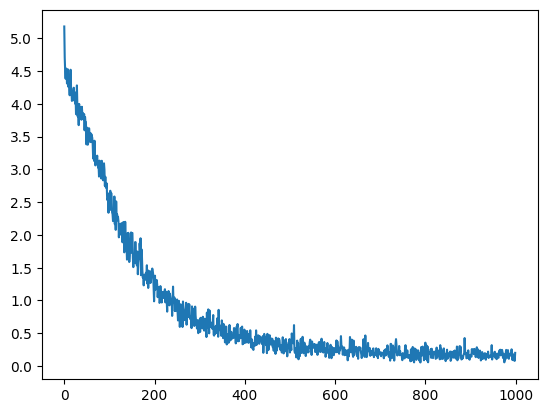

In [20]:
hidden_size = 1024
encoder = EncoderGRU(input_lang.n_words, hidden_size).to(device)
decoder = AttentionDecoder(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
train_iters(encoder, decoder, n_iters=100000, print_every=5000)

### 4. Оценка качества модели машинного перевода

#### 4.1 Визуальная оценка качества машинного перевода

Модель неплохо предсказывает короткие предложения. Однако чем более длинным оказывается предложение, тем выше частота ошибок. Наблюдается потеря последних слов в предложении. Возможно, это следствие введенного штрафа за длину предсказанного предложения. Однако причиной этого также может быть потеря внимания на длинном предложении.

In [21]:
score = evaluate_randomly(encoder, decoder, n=1000)

> i am not sleeping .
= я не сплю .
< я не сплю . <EOS>

> money cannot buy happiness .
= за грошы шчасця не купіш .
< за грошы шчасця не купіш . <EOS>

> i am going to bed .
= я кладуся спаць !
< я кладуся спаць . <EOS>

> i am a police officer .
= я міліцыянерка .
< я міліцыянерка . <EOS>

> we are good friends .
= мы добрыя сябры .
< мы добрыя сябры . <EOS>

> make yourself at home .
= будзь як у сябе .
< будзь як у сябе . <EOS>

> what is that ?
= што гэта ?
< што гэта такое ? <EOS>

> do you believe in ghosts ?
= ці верыце вы ў прывіды ?
< ты верыш у зданяў ? <EOS>

> you are the best .
= ты лепш за ўсіх .
< ты лепшая за ўсіх . <EOS>

> i am the owner of this building .
= я ўласніца гэтага будынка .
< я ўласніца гэтага будынка . <EOS>

> i ordered a pizza .
= я замовіла піцу .
< я замовіла піцу . <EOS>

> i never learned to play tennis .
= я ніколі не вучыўся гуляць у тэніс .
< я ніколі не вучыўся гуляць у тэніс . <EOS>

> bring your sister next time .
= наступны раз прыходзь з ся

#### 4.2 Оценка качества машинного перевода с помощью оценки BLEU на случайно отобранных парах предложений

In [38]:
import pandas as pd
import numpy as np

score = bleu.compute(predictions=predictions, references=references)

df = pd.DataFrame({
    'bleu_score': [score['bleu']] + [np.nan] * 3,
    'precisions': score['precisions'],
    'brevity_penalty': [score['brevity_penalty']] + [np.nan] * 3,
    'length_ratio': [score['length_ratio']] + [np.nan] * 3,
    'translation_length': [score['translation_length']] + [np.nan] * 3,
    'reference_length': [score['reference_length']] + [np.nan] * 3
})

df.T

,0,1,2,3
bleu_score,0.518226,NaN,NaN,NaN
precisions,0.622657,0.558917,0.494951,0.418714
brevity_penalty,1.000000,NaN,NaN,NaN
length_ratio,1.540794,NaN,NaN,NaN
translation_length,8536.000000,NaN,NaN,NaN
reference_length,5540.000000,NaN,NaN,NaN


## Заключение

Подготовлена и обучена модель машинного перевода с английского на беларусский язык, а также выполнена оценка качества такого перевода. По результатам этой работы можно сделать следующие выводы:

1. Увеличение скорости обучения с 0,01 до 0,001 приводило к тому, что функция потерь требовала значительно больше итераций для достижения приемлемых значений. При этом при количестве итераций, равном 75 000, функция потерь не сходилась. Поэтому для обеспечения приемлемой скорости обучения было принято решение оставить значение скорости обучения, равное 0,01.

2. Замена оптимизатора с SGD на Adam или AdamW приводило к тому, что функция потерь не сходилась.

3. Увеличение величины скрытого слоя с 512 до 1024 и 2048 приводило к чуть лучшим результатам, однако несколько увеличивало время обучения.

4. Увеличение количества итераций при обучении приводило к незначительному улучшению качества предсказаний модели, но практически пропорционально изменению количества итераций увеличивало время обучения.

5. Изучено влияние включения штрафа за длину предсказанного предложения. Данный штраф был включен в модель вследствие того, что оценка BLEU (в частности, параметр 'length_ratio', равный около 1,5) свидетельствовала о том, что длина предсказанного предложения на целевом языке в 1,5 раза больше длины эталонного предложения на целевом языке. В попытке уменьшить это отношение был введен штраф за длину предсказанного предложения. Влияние штрафа оценивали путем варьирования параметра альфа. Однако заметного изменения качества модели добиться не удалось.

6. Изучено влияние включения или удаления дополнительных скрытых слоев на качество модели. В скрытые слои энкодера были добавлены слои активации ReLU, Dropout и нормировочный слой Layer_Norm (в том числе были изучено влияние их положения относительно слоя GRU). В скрытые слои декодера были добавлены либо удалены дополнительные слои ReLU и Dropout (так же с учетом положения относительно слоя GRU). В частности, была выдвинута гипотеза о том, что исключение слоя Dropout после слоя эмбеддингов в декодере позволит улучшить качество модели вследствие того, что некоторые узлы больше не будут обнуляться, что не будет приводить к потере информации. Эта гипотеза не была подтверждена. Добавление нормировочного слоя после слоя эмбеддингов в энкодере (наподобие архитектуры трансформеров) не приводило к улучшению модели. В целом, ни один из дополнительных слоев не приводил к улучшению качества модели, однако зачастую отмечалось существенное ухудшение значений функции потерь. При обучении схождения функции потерь не достигалось. Возможно, увеличение объема словаря и количества итераций нивелировало бы эту проблему, но это было недоступно.

7. Была проведена попытка использования лучевого поиска лучшего варианта предсказаний (с использованием 3 лучей) вместо жадного отбора лучшего варианта предсказания каждого последующего слова в предложении. Однако приемлемого результата добиться не удалось. Качество предсказаний было очень плохим, и настроить модель для получения приемлемого результата не удалось.

В качестве заключения следует отметить, что качество модели машинного перевода среднее. Она неплохо предсказывает н-граммы состоящие из 1 и 2 слов, но при увеличении количества слов в н-граммах качество модели сильно ухудшается. Исходя из приведенной выше информации, можно утверждать, что качество модели определяется объемом словаря и выбором модели рекуррентной нейронной сети (в данном случае GRU). Наверняка, увеличение объема словаря привело бы к улучшению качества. Возможно, более высокие результаты были бы получены при замене модели GRU на LSTM, поскольку она имеет два функции памяти в отличие от GRU и, не исключено, лучше сохраняет информацию в случае длинных предложений (больших н-грамм).